In [1]:
!pip install pytorch-model-summary

In [98]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from datetime import datetime
from statistics import mean, median
from torch.utils.data import Dataset
import math
from torchvision.io import read_image
from pathlib import Path
from scipy.linalg import sqrtm

from pytorch_model_summary import summary as sum

from tqdm import tqdm


In [3]:
dataroot = "../input/lsun_bedroom/data0/lsun/bedroom"

In [4]:
image_size = 64
workers = 2

In [5]:
def _load_folder_list(root):
    return  list(str(p)[len(root)+ 1:] for p in Path(root).rglob("*.jpg"))

class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, ):
        self.img_dir = img_dir
        self.transform = transform
        self.filenames = _load_folder_list(img_dir)
        

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        image = (read_image(img_path,) / 255)
        label = 0
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
dataset = ImageDataset(dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [8]:
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

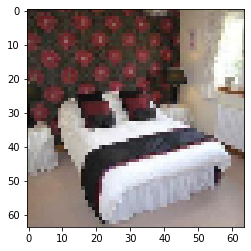

In [9]:
im = transforms.ToPILImage()(unorm(dataset[5][0])).convert("RGB")
plt.imshow(im)

In [15]:
def weights_init(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [13]:
def norm_grad(model):
    total_norm = 0
    parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
    for p in parameters:
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

**DCGAN**

In [9]:
lr = 0.0002
batch_size = 128
noiseDimension = 100

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [ ]:
chanals_generator= [1024,512,256,128]
generator = nn.Sequential(
        # (1,1,100)
        nn.ConvTranspose2d(noiseDimension, chanals_generator[0], 4, 1, 0, bias=False),
        nn.BatchNorm2d(chanals_generator[0]),
        nn.LeakyReLU(0.2, inplace=True),
        # (4,4,1024)
        nn.ConvTranspose2d(chanals_generator[0], chanals_generator[1], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[1]),
        nn.LeakyReLU(0.2, inplace=True),
        # (8,8,512)
        nn.ConvTranspose2d(chanals_generator[1], chanals_generator[2], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[2]),
        nn.LeakyReLU(0.2, inplace=True),
        # (16,16,256)
        nn.ConvTranspose2d(chanals_generator[2], chanals_generator[3], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[3]),
        nn.LeakyReLU(0.2, inplace=True),
        # (32,32,128)
        nn.ConvTranspose2d( chanals_generator[3], 3, 4, 2, 1, bias=False),
        #(64,64,3)
        nn.Tanh()
).cuda()
weights_init(generator)

In [ ]:
print(sum(generator, torch.zeros((1,noiseDimension,1,1)).cuda(), show_input=False))

In [17]:
chanals_discriminator= [64,128,256,512]
discriminator = nn.Sequential(
        nn.Conv2d(3, chanals_discriminator[0], 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(chanals_discriminator[0], chanals_discriminator[1], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_discriminator[1]),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0,4),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(chanals_discriminator[1], chanals_discriminator[2], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_discriminator[2]),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0,4),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(chanals_discriminator[2], chanals_discriminator[3], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_discriminator[3]),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0,4),
        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(chanals_discriminator[3], 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
).cuda()
weights_init(discriminator)

In [ ]:
print(sum(discriminator, torch.zeros((1,3,image_size,image_size)).cuda(), show_input=False))

In [ ]:
# Initialize BCELoss function
loss_function = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(6, noiseDimension, 1, 1).cuda()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
def train(generator,discriminator, dataloader, num_epochs, optimizerD, optimizerG, loss_function, printAfteBatch = 500, 
          cols = 3,chunk = 100, n_critic = 1):    
    G_losses = []; D_losses = []; iter = 0; last_iter = 0; chunk_errD = []; chunk_errG = []; chunk_lossD = []; chunk_lossG = []
    chunk_mean_D = []; chunk_mean_G = []; chunk_mean_lossD = []; chunk_mean_lossG = []; norm_gradD = []; norm_gradG = []
    
    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
            for batch_idx, train_batch in epoch_progress:
                #Update discriminator
                for _ in range(n_critic):
                    #Train on real images
                    discriminator.zero_grad()
                    x,_ = train_batch
                    x = x.cuda()
                    y =  torch.full((x.shape[0],), real_label, dtype=torch.float).cuda()
                    output = discriminator(x).view(-1)
                    lossD_real = loss_function(output,y)
                    errD = output.mean().item()

                    #Train on fake images
                    noise = torch.randn(x.shape[0], noiseDimension, 1, 1).cuda()
                    y =  torch.full((x.shape[0],), fake_label, dtype=torch.float).cuda()
                    fake_image = generator(noise)
                    output = discriminator(fake_image).view(-1)
                    lossD_fake = loss_function(output,y)

                    errG_disc = output.mean().item()

                    lossD = (lossD_real + lossD_fake) / 2
                    lossD.backward(retain_graph = True)
                    optimizerD.step()
                
                #Update generator
                generator.zero_grad()
                y_real =  torch.full((x.shape[0],), real_label, dtype=torch.float).cuda()
                output = discriminator(fake_image).view(-1)
                lossG = loss_function(output,y_real)
                lossG.backward()
                errG_gen = output.mean().item()
                
                optimizerG.step()
                
                G_losses.append(lossG.item())
                D_losses.append(lossD.item())
                
                chunk_errD.append(errD)
                chunk_errG.append(errG_gen) 
                chunk_lossD.append(lossD.item())
                chunk_lossG.append(lossG.item())
                
                norm_gradD.append(norm_grad(discriminator))
                norm_gradG.append(norm_grad(generator))
                
                epoch_progress.set_postfix({
                    'lossD': lossD.item(),
                    'lossG': lossG.item(),
                    'errD' : errD,
                    'errG_disc' : errG_disc,
                    'errG_gen' : errG_gen
                }) 
                if iter > 0 and iter % chunk == 0:
                    chunk_mean_D.append(mean(chunk_errD))
                    chunk_mean_G.append(mean(chunk_errG))
                    chunk_mean_lossD.append(mean(chunk_lossD))
                    chunk_mean_lossG.append(mean(chunk_lossG))
                    chunk_errD = []
                    chunk_errG = []
                    chunk_lossG = []
                    chunk_lossD = []
        
        
                if iter % printAfteBatch == 0:
                    with torch.no_grad():
                        fake_test = generator(fixed_noise).detach().cpu()
                        
                    plt.figure(figsize=(18, 30), dpi=160)
                    i = 0
                    for im in fake_test:
                        i += 1

                        plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                        plt.axis('off')
                        plt.imshow(np.transpose(unorm(im),(1,2,0)))
                        
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.axis('on')
                    plt.title("Mean of positive labels on real data", loc = 'left')
                    plt.plot( list(range(len(chunk_mean_D))),chunk_mean_D,label='chunk_mean_D')
                    
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("Mean of positive labels on fake data", loc = 'left')
                    plt.plot(list(range(len(chunk_mean_lossG))),chunk_mean_G,label='chunk_mean_G')
                    
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("Mean of loss disicriminator", loc = 'left')
                    plt.plot(list(range(len(chunk_mean_lossD))),chunk_mean_lossD,label='chunk_mean_G')
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("Mean of loss generator", loc = 'left')
                    plt.plot(list(range(len(chunk_mean_lossG))),chunk_mean_lossG,label='chunk_mean_G')
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("Gradient discriminator", loc = 'left')
                    plt.plot(list(range(len(norm_gradD))),norm_gradD,label='chunk_mean_G')
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("gradient generator", loc = 'left')
                    plt.plot(list(range(len(norm_gradG))),norm_gradG,label='chunk_mean_G')
                    plt.show()
                iter += 1
    
    return G_losses,D_losses

In [ ]:
# Speed ups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

In [ ]:
G_losses,D_losses = train(generator,discriminator, dataloader,5,optimizerD, optimizerG, loss_function)

In [ ]:
test_noise = torch.randn(40, noiseDimension, 1, 1).cuda()
with torch.no_grad():
    fake_test = generator2(test_noise).detach().cpu()

plt.figure(figsize=(30, 90), dpi=160)
i = 0
for im in fake_test:
    i += 1

    plt.subplot(10,4, i)
    plt.axis('off')
    plt.imshow(np.transpose(unorm(im),(1,2,0)))

In [ ]:
model_scripted = torch.jit.script(generator) # Export to TorchScript
model_scripted.save('./model_generator0_1.pt') 
model_scripted = torch.jit.script(discriminator) # Export to TorchScript
model_scripted.save('./model_discriminator0_2.pt') 

In [ ]:
plt.figure(figsize=(18, 10), dpi=160)
plt.plot(list(range(len(D_losses))),D_losses)
plt.ylim(0, 2)

**WGAN**

In [ ]:
lr1 = 0.00005
weight_clip = 0.01
n_critic = 5
batch_size = 64
noiseDimension = 100

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [ ]:
chanals_generator= [1024,512,256,128]
generator1 = nn.Sequential(
        # (1,1,100)
        nn.ConvTranspose2d(noiseDimension, chanals_generator[0], 4, 1, 0, bias=False),
        nn.BatchNorm2d(chanals_generator[0]),
        nn.LeakyReLU(0.2, inplace=True),
        # (4,4,512)
        nn.ConvTranspose2d(chanals_generator[0], chanals_generator[1], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[1]),
        nn.LeakyReLU(0.2, inplace=True),
        # (0,8,256)
        nn.ConvTranspose2d(chanals_generator[1], chanals_generator[2], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[2]),
        nn.LeakyReLU(0.2, inplace=True),
        # (16,16,128)
        nn.ConvTranspose2d(chanals_generator[2], chanals_generator[3], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[3]),
        nn.LeakyReLU(0.2, inplace=True),
        # (32,32,64)
        nn.ConvTranspose2d( chanals_generator[3], 3, 4, 2, 1, bias=False),
        nn.Tanh()
).cuda()
generator1.apply(weights_init)

In [ ]:
print(sum(generator1, torch.zeros((1,noiseDimension,1,1)).cuda(), show_input=False))

In [ ]:
chanals_discriminator= [64,128,256,512]
discriminator1 = nn.Sequential(
        nn.Conv2d(3, chanals_discriminator[0], 4, 2, 1, bias=False,),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(chanals_discriminator[0], chanals_discriminator[1], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_discriminator[1]),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(chanals_discriminator[1], chanals_discriminator[2], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_discriminator[2]),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(chanals_discriminator[2], chanals_discriminator[3], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_discriminator[3]),
        nn.LeakyReLU(0.2, inplace=True),
         # state size. (ndf*4) x 4 x 4
        nn.Conv2d(chanals_discriminator[3],1, 4, 2, 0, bias=False),
   
).cuda()

In [ ]:
print(sum(discriminator1, torch.zeros((1,3,image_size,image_size)).cuda(), show_input=False))

In [ ]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(6, noiseDimension, 1, 1).cuda()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup RMSprop optimizers for both G and D
optimizerD1 = optim.RMSprop(discriminator1.parameters(), lr=lr1)
optimizerG1 = optim.RMSprop(generator1.parameters(), lr=lr1)

In [ ]:
def train1(generator,discriminator, dataloader, num_epochs, optimizerD, optimizerG, printAfteBatch = 500, cols = 3,chunk = 100,
           n_critic = 1):    
    G_losses = []; D_losses = []; iter = 0; last_iter = 0; chunk_errD = []; chunk_errG = []; chunk_lossD = []; chunk_lossG = [];
    chunk_mean_D = []; chunk_mean_G = []; chunk_mean_lossD = []; chunk_mean_lossG = []; norm_gradD = []; norm_gradG = []
    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
            for batch_idx, train_batch in epoch_progress:
                #Update discriminator
                for _ in range(n_critic):
                    #Train on real images
                    discriminator.zero_grad()
                    x,_ = train_batch
                    x = x.cuda()
                    y =  torch.full((x.shape[0],), real_label, dtype=torch.float).cuda()
                    output_real = discriminator(x).view(-1)

                    errD = output_real.mean().item()

                    #Train on fake images
                    noise = torch.randn(x.shape[0], noiseDimension, 1, 1).cuda()
                    y.fill_(fake_label)
                    fake_image = generator(noise)
                    output_fake = discriminator(fake_image.detach()).view(-1)

                    errG_disc = output_fake.mean().item()

                    lossD = -(torch.mean(output_real) - torch.mean(output_fake))
                    lossD.backward(retain_graph = True)
                    optimizerD.step()
                    
                    for p in discriminator.parameters():
                        p.data.clamp_(-weight_clip,weight_clip)
                
                #Update generator
                generator.zero_grad()
                y_real =  torch.full((x.shape[0],), real_label, dtype=torch.float).cuda()
                output = discriminator(fake_image).view(-1)
                lossG = -torch.mean(output)
                lossG.backward()
                
                errG_gen = output.mean().item()
                
                optimizerG.step()
                
                G_losses.append(lossG.item())
                D_losses.append(lossD.item())
                
                chunk_errD.append(errD)
                chunk_errG.append(errG_gen) 
                chunk_lossD.append(lossD.item())
                chunk_lossG.append(lossG.item())
                
                norm_gradD.append(norm_grad(discriminator))
                norm_gradG.append(norm_grad(generator))
                
                epoch_progress.set_postfix({
                    'lossD': lossD.item(),
                    'lossG': lossG.item(),
                    'errD' : errD,
                    'errG_disc' : errG_disc,
                    'errG_gen' : errG_gen
                }) 
        
        
                if iter % printAfteBatch == 0:
                    with torch.no_grad():
                        fake_test = generator(fixed_noise).detach().cpu()
                        
                    plt.figure(figsize=(18, 30), dpi=160)
                    i = 0
                    for im in fake_test:
                        i += 1

                        plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                        plt.axis('off')
                        plt.imshow(np.transpose(unorm(im),(1,2,0)))
                        
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.axis('on')
                    plt.title("Median of positive labels on real data", loc = 'left')
                    plt.plot( list(range(len(chunk_mean_D))),chunk_mean_D,label='chunk_mean_D')
                    
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("Median of positive labels on fake data", loc = 'left')
                    plt.plot(list(range(len(chunk_mean_lossG))),chunk_mean_G,label='chunk_mean_G')
                    
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("Median of loss disicriminator", loc = 'left')
                    plt.plot(list(range(len(chunk_mean_lossD))),chunk_mean_lossD,label='chunk_mean_G')
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("Median of loss generator", loc = 'left')
                    plt.plot(list(range(len(chunk_mean_lossG))),chunk_mean_lossG,label='chunk_mean_G')
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("Gradient discriminator", loc = 'left')
                    plt.plot(list(range(len(norm_gradD))),norm_gradD,label='chunk_mean_G')
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+6 /cols),cols, i)
                    plt.title("gradient generator", loc = 'left')
                    plt.plot(list(range(len(norm_gradG))),norm_gradG,label='chunk_mean_G')
                    plt.show()
                iter += 1
    
    return G_losses,D_losses

In [ ]:
# Speed ups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

In [ ]:
#Becuase of lost conection with GPU i needed to refresh keras notebook so my outputs disepear, becuase of that i loded models and just produce example of output
G_losses1,D_losses1 = train1(generator1,discriminator1, dataloader,5,optimizerD1, optimizerG1,n_critic = n_critic)

**WGAN_GP**

In [ ]:
lr2 = 0.0001
n_critic2 = 5
lambda_gp = 10
batch_size = 64
noiseDimension = 100

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [ ]:
chanals_generator= [512,256,128,64]
generator2 = nn.Sequential(
        # (1,1,100)
        nn.ConvTranspose2d(noiseDimension, chanals_generator[0], 4, 1, 0, bias=False),
        nn.BatchNorm2d(chanals_generator[0]),
        nn.LeakyReLU(0.2, inplace=True),
        # (4,4,512)
        nn.ConvTranspose2d(chanals_generator[0], chanals_generator[1], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[1]),
        nn.LeakyReLU(0.2, inplace=True),
        # (0,8,256)
        nn.ConvTranspose2d(chanals_generator[1], chanals_generator[2], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[2]),
        nn.LeakyReLU(0.2, inplace=True),
        # (16,16,128)
        nn.ConvTranspose2d(chanals_generator[2], chanals_generator[3], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[3]),
        nn.LeakyReLU(0.2, inplace=True),
        # (32,32,64)
        nn.ConvTranspose2d( chanals_generator[3], 3, 4, 2, 1, bias=False),
        nn.Tanh()
).cuda()
weights_init(generator2)

In [ ]:
print(sum(generator2, torch.zeros((1,noiseDimension,1,1)).cuda(), show_input=False))

In [ ]:
chanals_discriminator= [64,128,256,512]
discriminator2 = nn.Sequential(
        nn.Conv2d(3, chanals_discriminator[0], 4, 2, 1, bias=False,),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(chanals_discriminator[0], chanals_discriminator[1], 4, 2, 1, bias=False),
        nn.InstanceNorm2d(chanals_discriminator[1],affine = True),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(chanals_discriminator[1], chanals_discriminator[2], 4, 2, 1, bias=False),
        nn.InstanceNorm2d(chanals_discriminator[2],affine = True),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(chanals_discriminator[2], chanals_discriminator[3], 4, 2, 1, bias=False),
        nn.InstanceNorm2d(chanals_discriminator[3],affine = True),
        nn.LeakyReLU(0.2, inplace=True),
         # state size. (ndf*4) x 4 x 4
        nn.Conv2d(chanals_discriminator[3], 1, 4, 2, 0, bias=False),
    
).cuda()
weights_init(discriminator2)

In [ ]:
print(sum(discriminator2, torch.zeros((1,3,image_size,image_size)).cuda(), show_input=False))

In [ ]:
generator2 = torch.jit.load('../input/wgan-gp-models/model_generator2 (1).pt')

discriminator2 = torch.jit.load('../input/wgan-gp-models/model_discriminator2 (1).pt')


In [ ]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(6, noiseDimension, 1, 1).cuda()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD2 = optim.Adam(discriminator2.parameters(), lr=lr2,betas= (0.0,0.90))
optimizerG2 = optim.Adam(generator2.parameters(), lr=lr2,betas= (0.0,0.90))

In [ ]:
def gradient_penalty(discriminator, real_iamges, fake_images):
    batch_size, c, h, w = real_iamges.shape
    epsilon = torch.rand((batch_size,1,1,1)).repeat(1,c,h,w).cuda()
    new_image = real_iamges * epsilon + (1 - epsilon) * fake_images
    score = discriminator(new_image)
    gradient = torch.autograd.grad(
        inputs = new_image, outputs = score, grad_outputs = torch.ones_like(score),create_graph = True ,retain_graph = True
    )[0]
    gradient = gradient.view(gradient.shape[0], - 1)
    norm = gradient.norm(2, dim = 1)
    penalty = torch.mean((norm-1) ** 2)
    return penalty

In [ ]:
def train2(generator,discriminator, dataloader, num_epochs, optimizerD, optimizerG, printAfteBatch = 500, cols = 3,
           chunk = 100, n_critic = 1):    
    G_losses = []; D_losses = []; iter = 0; last_iter = 0; errD_real = []; errD_fake = []; norm_gradD = []; norm_gradG = [] 
    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
            for batch_idx, train_batch in epoch_progress:
                #Update discriminator
                for _ in range(n_critic):
                    #Train real image
                    discriminator.zero_grad()
                    x,_ = train_batch
                    x = x.cuda()
                    output_real = discriminator(x).view(-1)

                    #Train fak image
                    noise = torch.randn(x.shape[0], noiseDimension, 1, 1).cuda()
                    fake_image = generator(noise)
                    output_fake = discriminator(fake_image).view(-1)
                   
                    gp = gradient_penalty(discriminator,x,fake_image)
                    lossD = -(torch.mean(output_real) - torch.mean(output_fake)) + lambda_gp * gp
                    
                    lossD.backward(retain_graph = True)
                    optimizerD.step()
                    
                    errD_real.append(output_real.mean().item())
                    errD_fake.append(output_fake.mean().item())
                    D_losses.append(lossD.item())
                
                #Update generator
                generator.zero_grad()
                output = discriminator(fake_image).view(-1)
                
                lossG = - torch.mean(output)
                
                lossG.backward()
                optimizerG.step()
                                
                G_losses.append(lossG.item())
                
                
                epoch_progress.set_postfix({
                    'lossD': lossD.item(),
                    'lossG': lossG.item(),
                }) 

                
                if iter % printAfteBatch == 0:
                    with torch.no_grad():
                        fake_test = generator(fixed_noise).detach().cpu()
                        
                    plt.figure(figsize=(18, 30), dpi=160)
                    i = 0
                    for im in fake_test:
                        i += 1

                        plt.subplot(math.ceil(fake_test.shape[0]+4 /cols),cols, i)
                        plt.axis('off')
                        plt.imshow(np.transpose(unorm(im),(1,2,0)))
                        
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+4 /cols),cols, i)
                    plt.axis('on')
                    plt.title("Output on real data", loc = 'left')
                    plt.plot( list(range(len(errD_real))),errD_real)
                    
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+4 /cols),cols, i)
                    plt.title("Output on fake data", loc = 'left')
                    plt.plot(list(range(len(errD_fake))),errD_fake)
                    
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+4 /cols),cols, i)
                    plt.title("Loss of discriminator", loc = 'left')
                    plt.plot(list(range(len(D_losses))),D_losses)
                    i += 1
                    plt.subplot(math.ceil(fake_test.shape[0]+4 /cols),cols, i)
                    plt.title("Loss of generator", loc = 'left')
                    plt.plot(list(range(len(G_losses))),G_losses)
                    plt.show()
                iter += 1
    
    return G_losses,D_losses

In [ ]:
# Speed ups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

In [ ]:
#Becuase of lost conection with GPU i needed to refresh keras notebook so my outputs disepear, becuase of that i loded models and just produce example of output
G_losses2,D_losses2 = train2(generator2,discriminator2, dataloader,5,optimizerD2, optimizerG2,n_critic = n_critic2)

In [ ]:
model_scripted = torch.jit.script(generator2) # Export to TorchScript
model_scripted.save('./model_generator2.pt') 
model_scripted = torch.jit.script(discriminator2) # Export to TorchScript
model_scripted.save('./model_discriminator2.pt') 

In [ ]:
plt.figure(figsize=(18, 10), dpi=160)
plt.plot(list(range(len(D_losses2[10:]))),D_losses2[10:])

In [ ]:
test_noise = torch.randn(40, noiseDimension, 1, 1).cuda()
with torch.no_grad():
    fake_test = generator2(test_noise).detach().cpu()

plt.figure(figsize=(30, 90), dpi=160)
i = 0
for im in fake_test:
    i += 1

    plt.subplot(10,4, i)
    plt.axis('off')
    plt.imshow(np.transpose(im,(1,2,0)))

**FID SCORE AND INTERPOLITED IMAGES**

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True).cuda()
a= model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [16]:
transform = transforms.Resize(299)

In [95]:
 def calculate_fid(real_embeddings, generated_embeddings):
    # calculate mean and covariance statistics

    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [82]:
real_images, _ = next(iter(dataloader))

In [88]:
with torch.no_grad():
    real_embeddings = model(transform(real_images[:64]).cuda()).cpu().numpy()

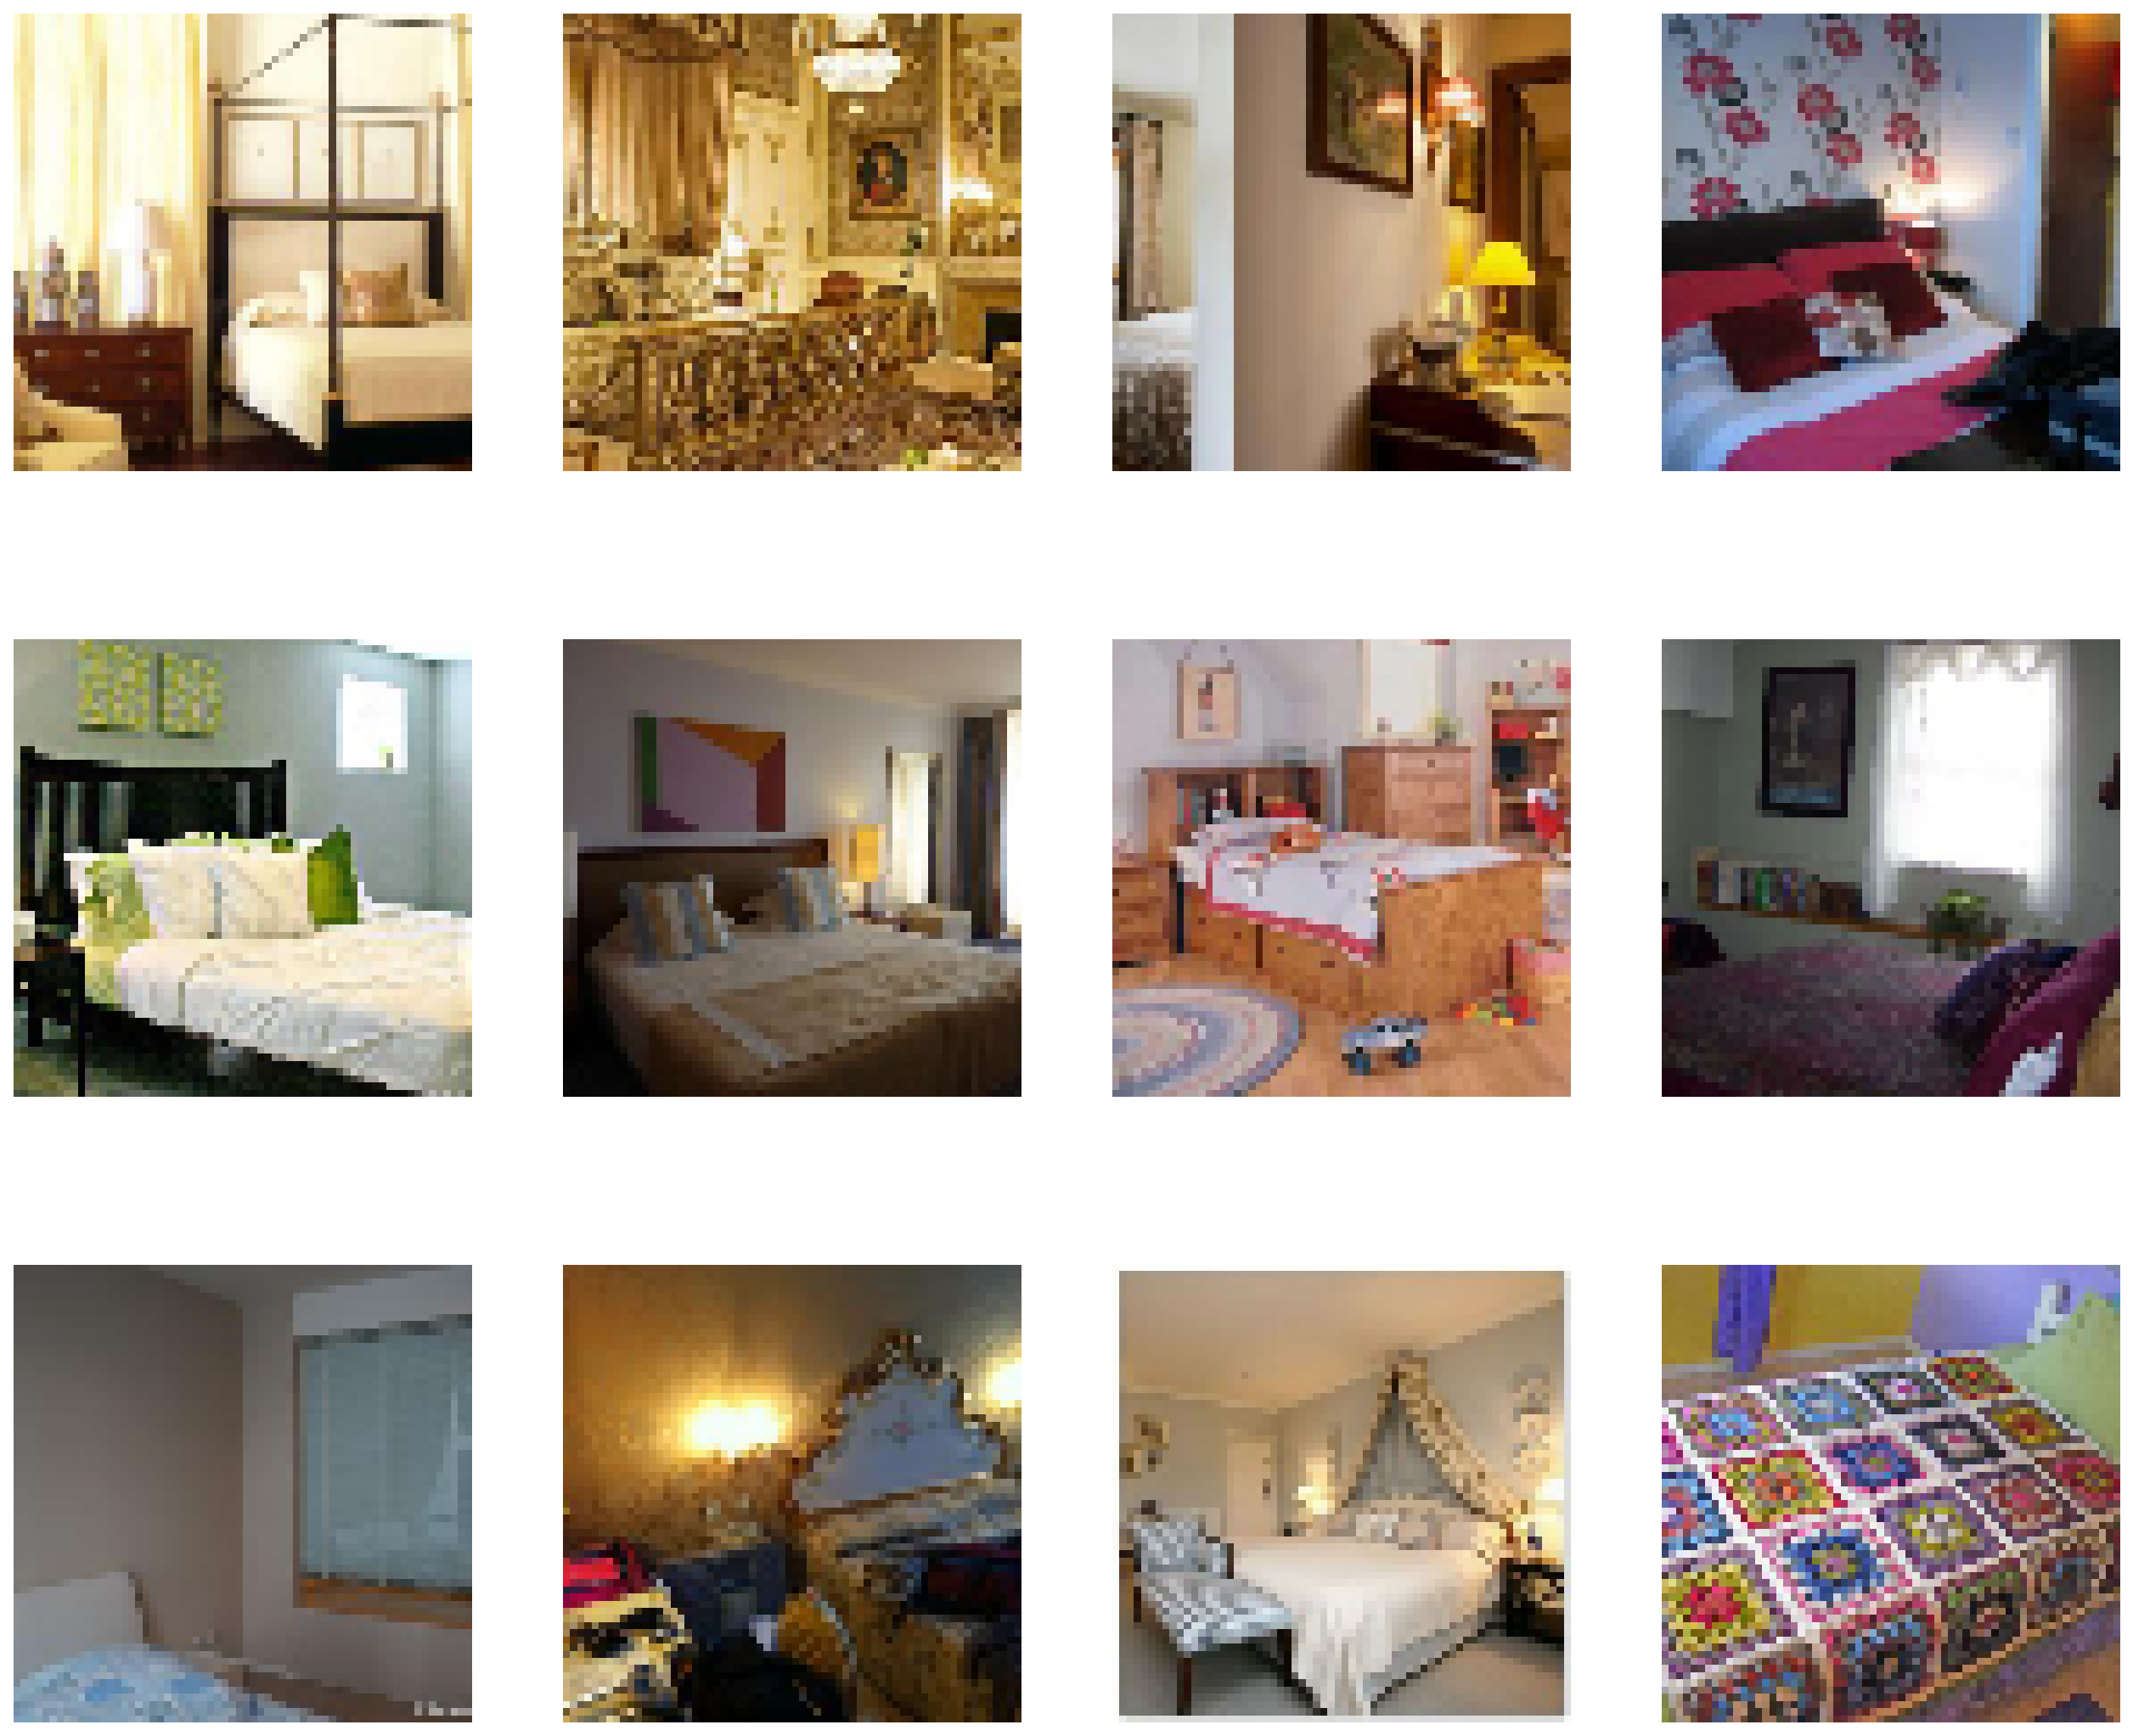

In [20]:
plt.figure(figsize=(20, 60), dpi=160)
i = 0
for im in real_images[0:12]:
    i += 1

    plt.subplot(10,4, i)
    plt.axis('off')
    plt.imshow(np.transpose(unorm(im),(1,2,0)))

In [21]:
chanals_generator= [1024,512,256,128]
generator = nn.Sequential(
        # (1,1,100)
        nn.ConvTranspose2d(noiseDimension, chanals_generator[0], 4, 1, 0, bias=False),
        nn.BatchNorm2d(chanals_generator[0]),
        nn.LeakyReLU(0.2, inplace=True),
        # (4,4,1024)
        nn.ConvTranspose2d(chanals_generator[0], chanals_generator[1], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[1]),
        nn.LeakyReLU(0.2, inplace=True),
        # (8,8,512)
        nn.ConvTranspose2d(chanals_generator[1], chanals_generator[2], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[2]),
        nn.LeakyReLU(0.2, inplace=True),
        # (16,16,256)
        nn.ConvTranspose2d(chanals_generator[2], chanals_generator[3], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[3]),
        nn.LeakyReLU(0.2, inplace=True),
        # (32,32,128)
        nn.ConvTranspose2d( chanals_generator[3], 3, 4, 2, 1, bias=False),
        #(64,64,3)
        nn.Tanh()
).cuda()
weights_init(generator)

In [135]:
#DCGAN load generator
generator = torch.jit.load('../input/dcganmodels/model_generator (1).pt')


In [23]:
test_noise = torch.randn(64, noiseDimension, 1, 1).cuda()

In [24]:
with torch.no_grad():
    fake_image = generator(test_noise).detach().cpu()

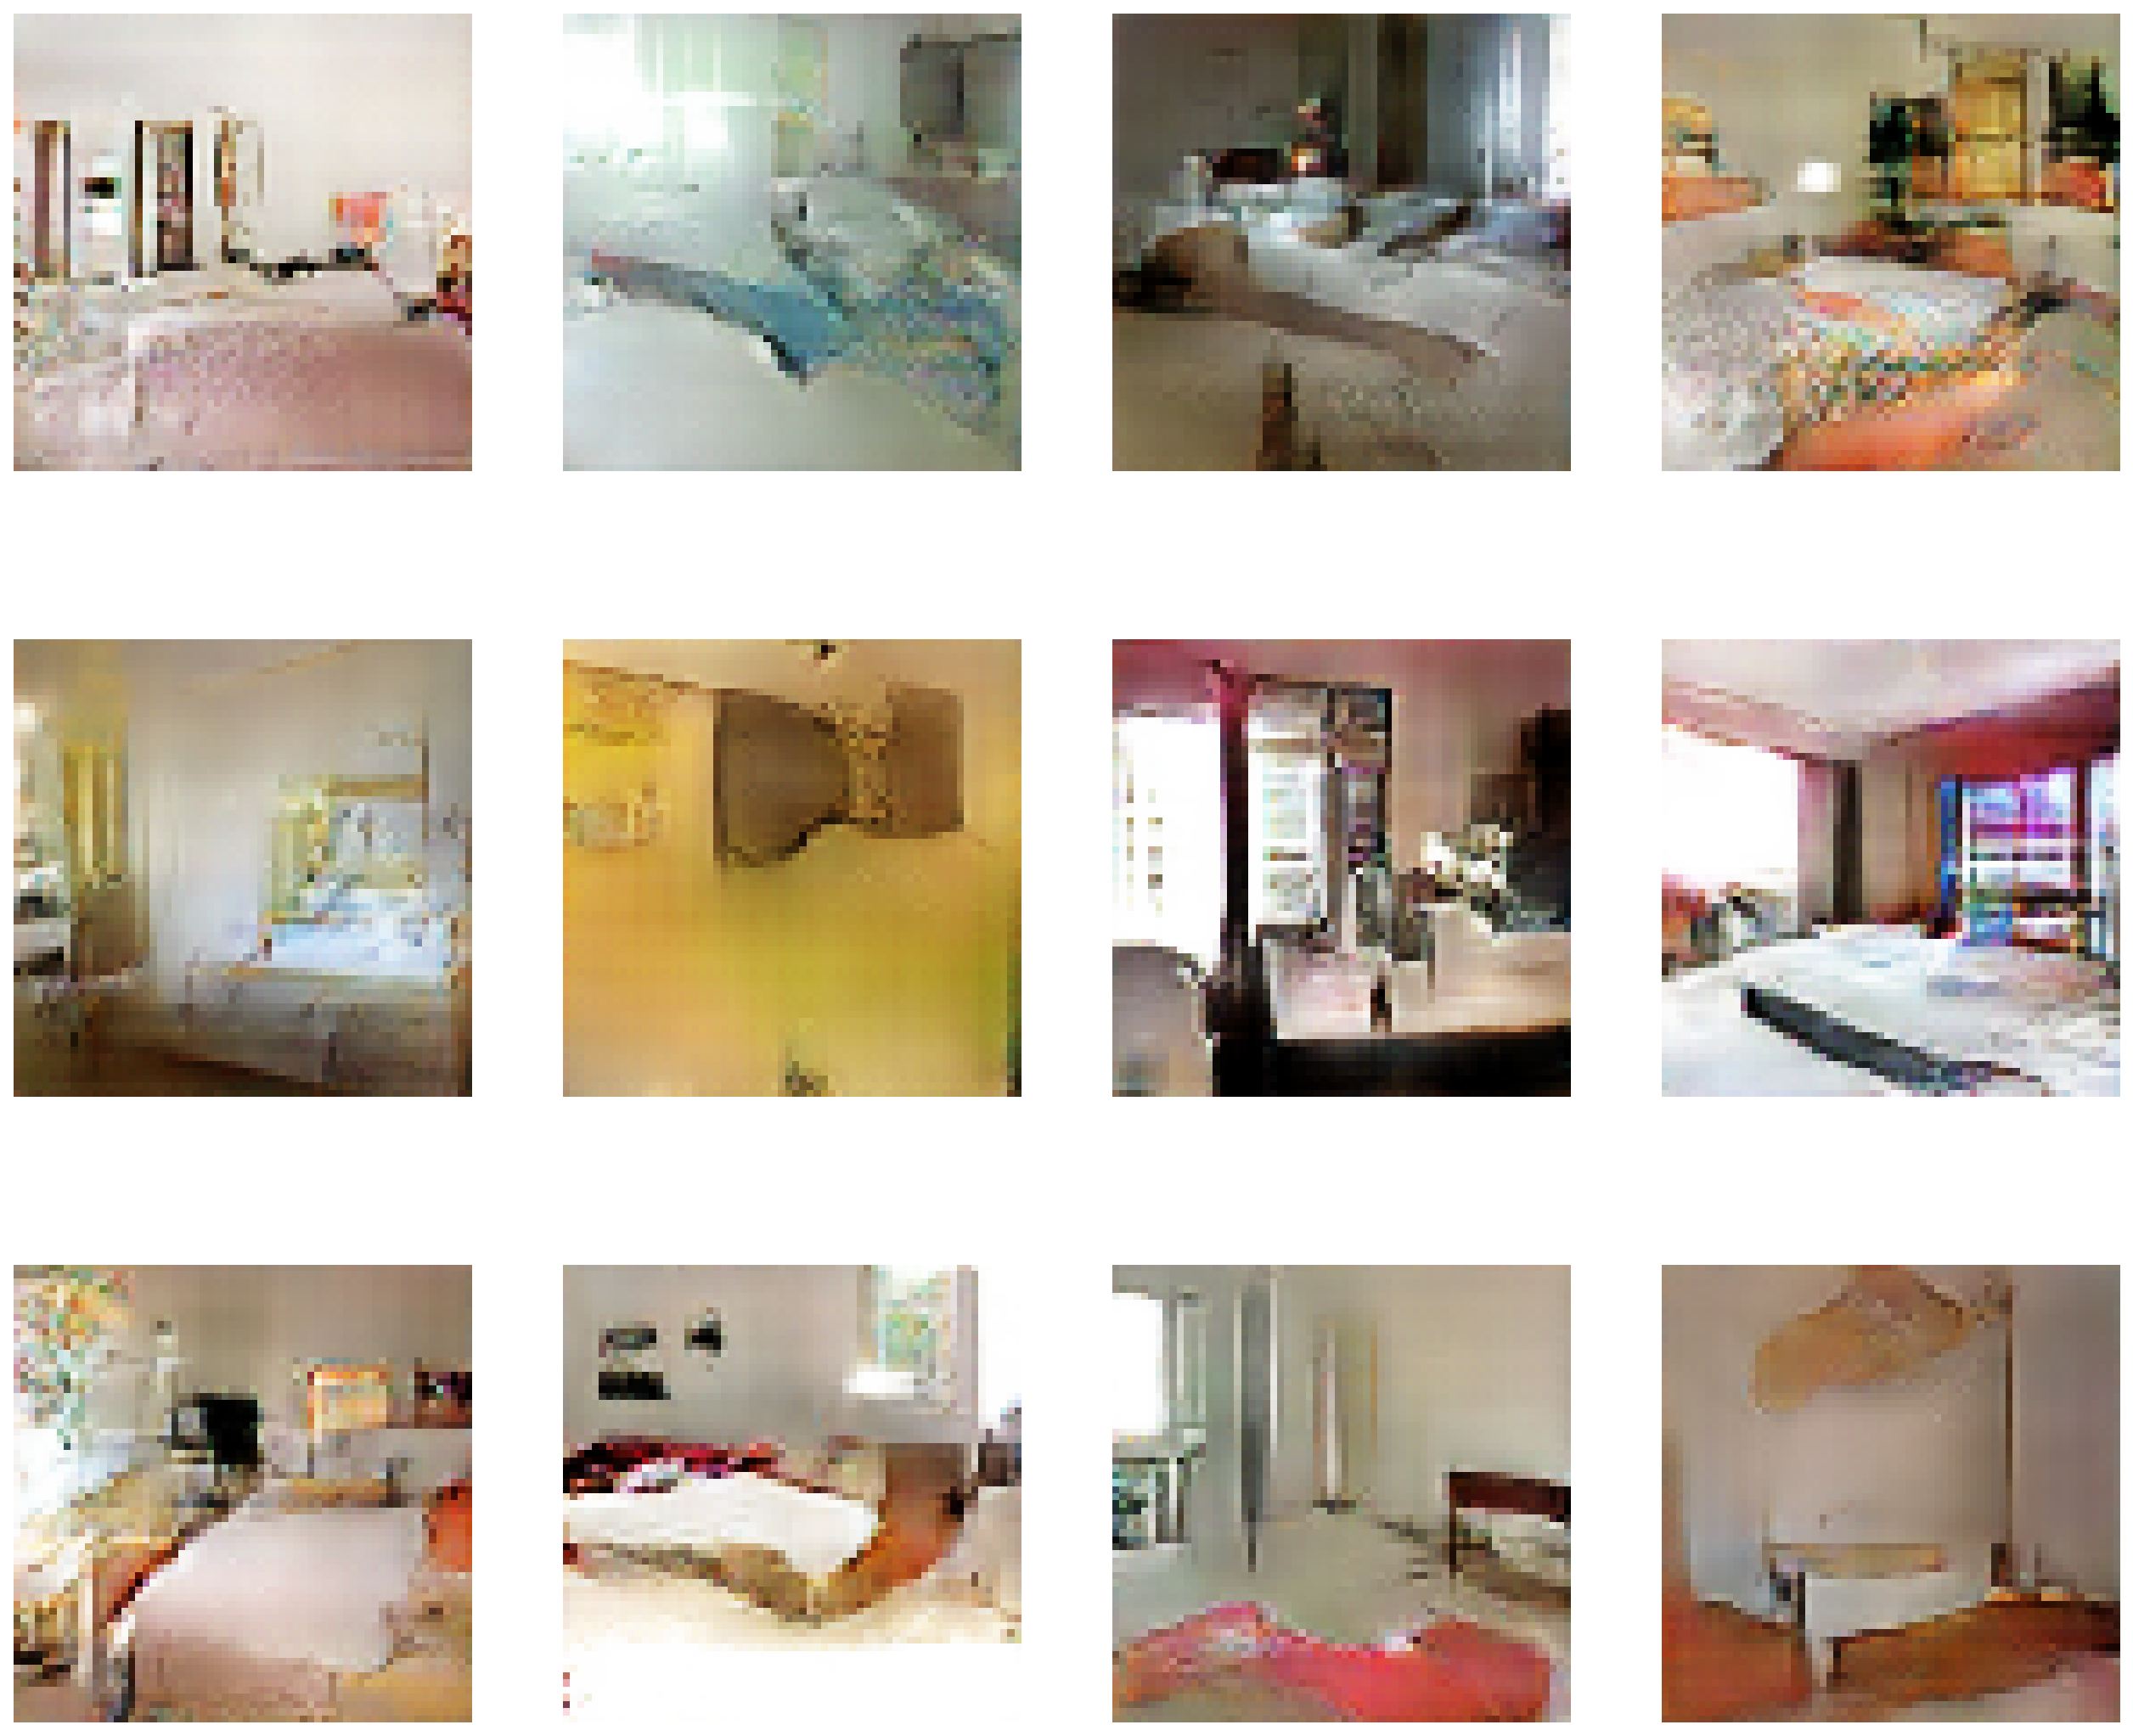

In [25]:
plt.figure(figsize=(20, 60), dpi=160)
i = 0
for im in fake_image[0:12]:
    i += 1

    plt.subplot(10,4, i)
    plt.axis('off')
    plt.imshow(np.transpose(unorm(im),(1,2,0)))

In [86]:
with torch.no_grad():
    generated_embeddings = model(transform(fake_image).cuda()).cpu().numpy()

In [99]:
calculate_fid(real_embeddings, generated_embeddings)

625.7710079333776

In [100]:
chanals_generator= [512,256,128,64]
generator2 = nn.Sequential(
        # (1,1,100)
        nn.ConvTranspose2d(noiseDimension, chanals_generator[0], 4, 1, 0, bias=False),
        nn.BatchNorm2d(chanals_generator[0]),
        nn.LeakyReLU(0.2, inplace=True),
        # (4,4,512)
        nn.ConvTranspose2d(chanals_generator[0], chanals_generator[1], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[1]),
        nn.LeakyReLU(0.2, inplace=True),
        # (0,8,256)
        nn.ConvTranspose2d(chanals_generator[1], chanals_generator[2], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[2]),
        nn.LeakyReLU(0.2, inplace=True),
        # (16,16,128)
        nn.ConvTranspose2d(chanals_generator[2], chanals_generator[3], 4, 2, 1, bias=False),
        nn.BatchNorm2d(chanals_generator[3]),
        nn.LeakyReLU(0.2, inplace=True),
        # (32,32,64)
        nn.ConvTranspose2d( chanals_generator[3], 3, 4, 2, 1, bias=False),
        nn.Tanh()
).cuda()
weights_init(generator2)

In [117]:
#WGAN_GP load generator
generator2 = torch.jit.load('../input/wgan-gp-models/model_generator2 (1).pt')

In [118]:
with torch.no_grad():
    fake_image = generator2(test_noise).detach().cpu()

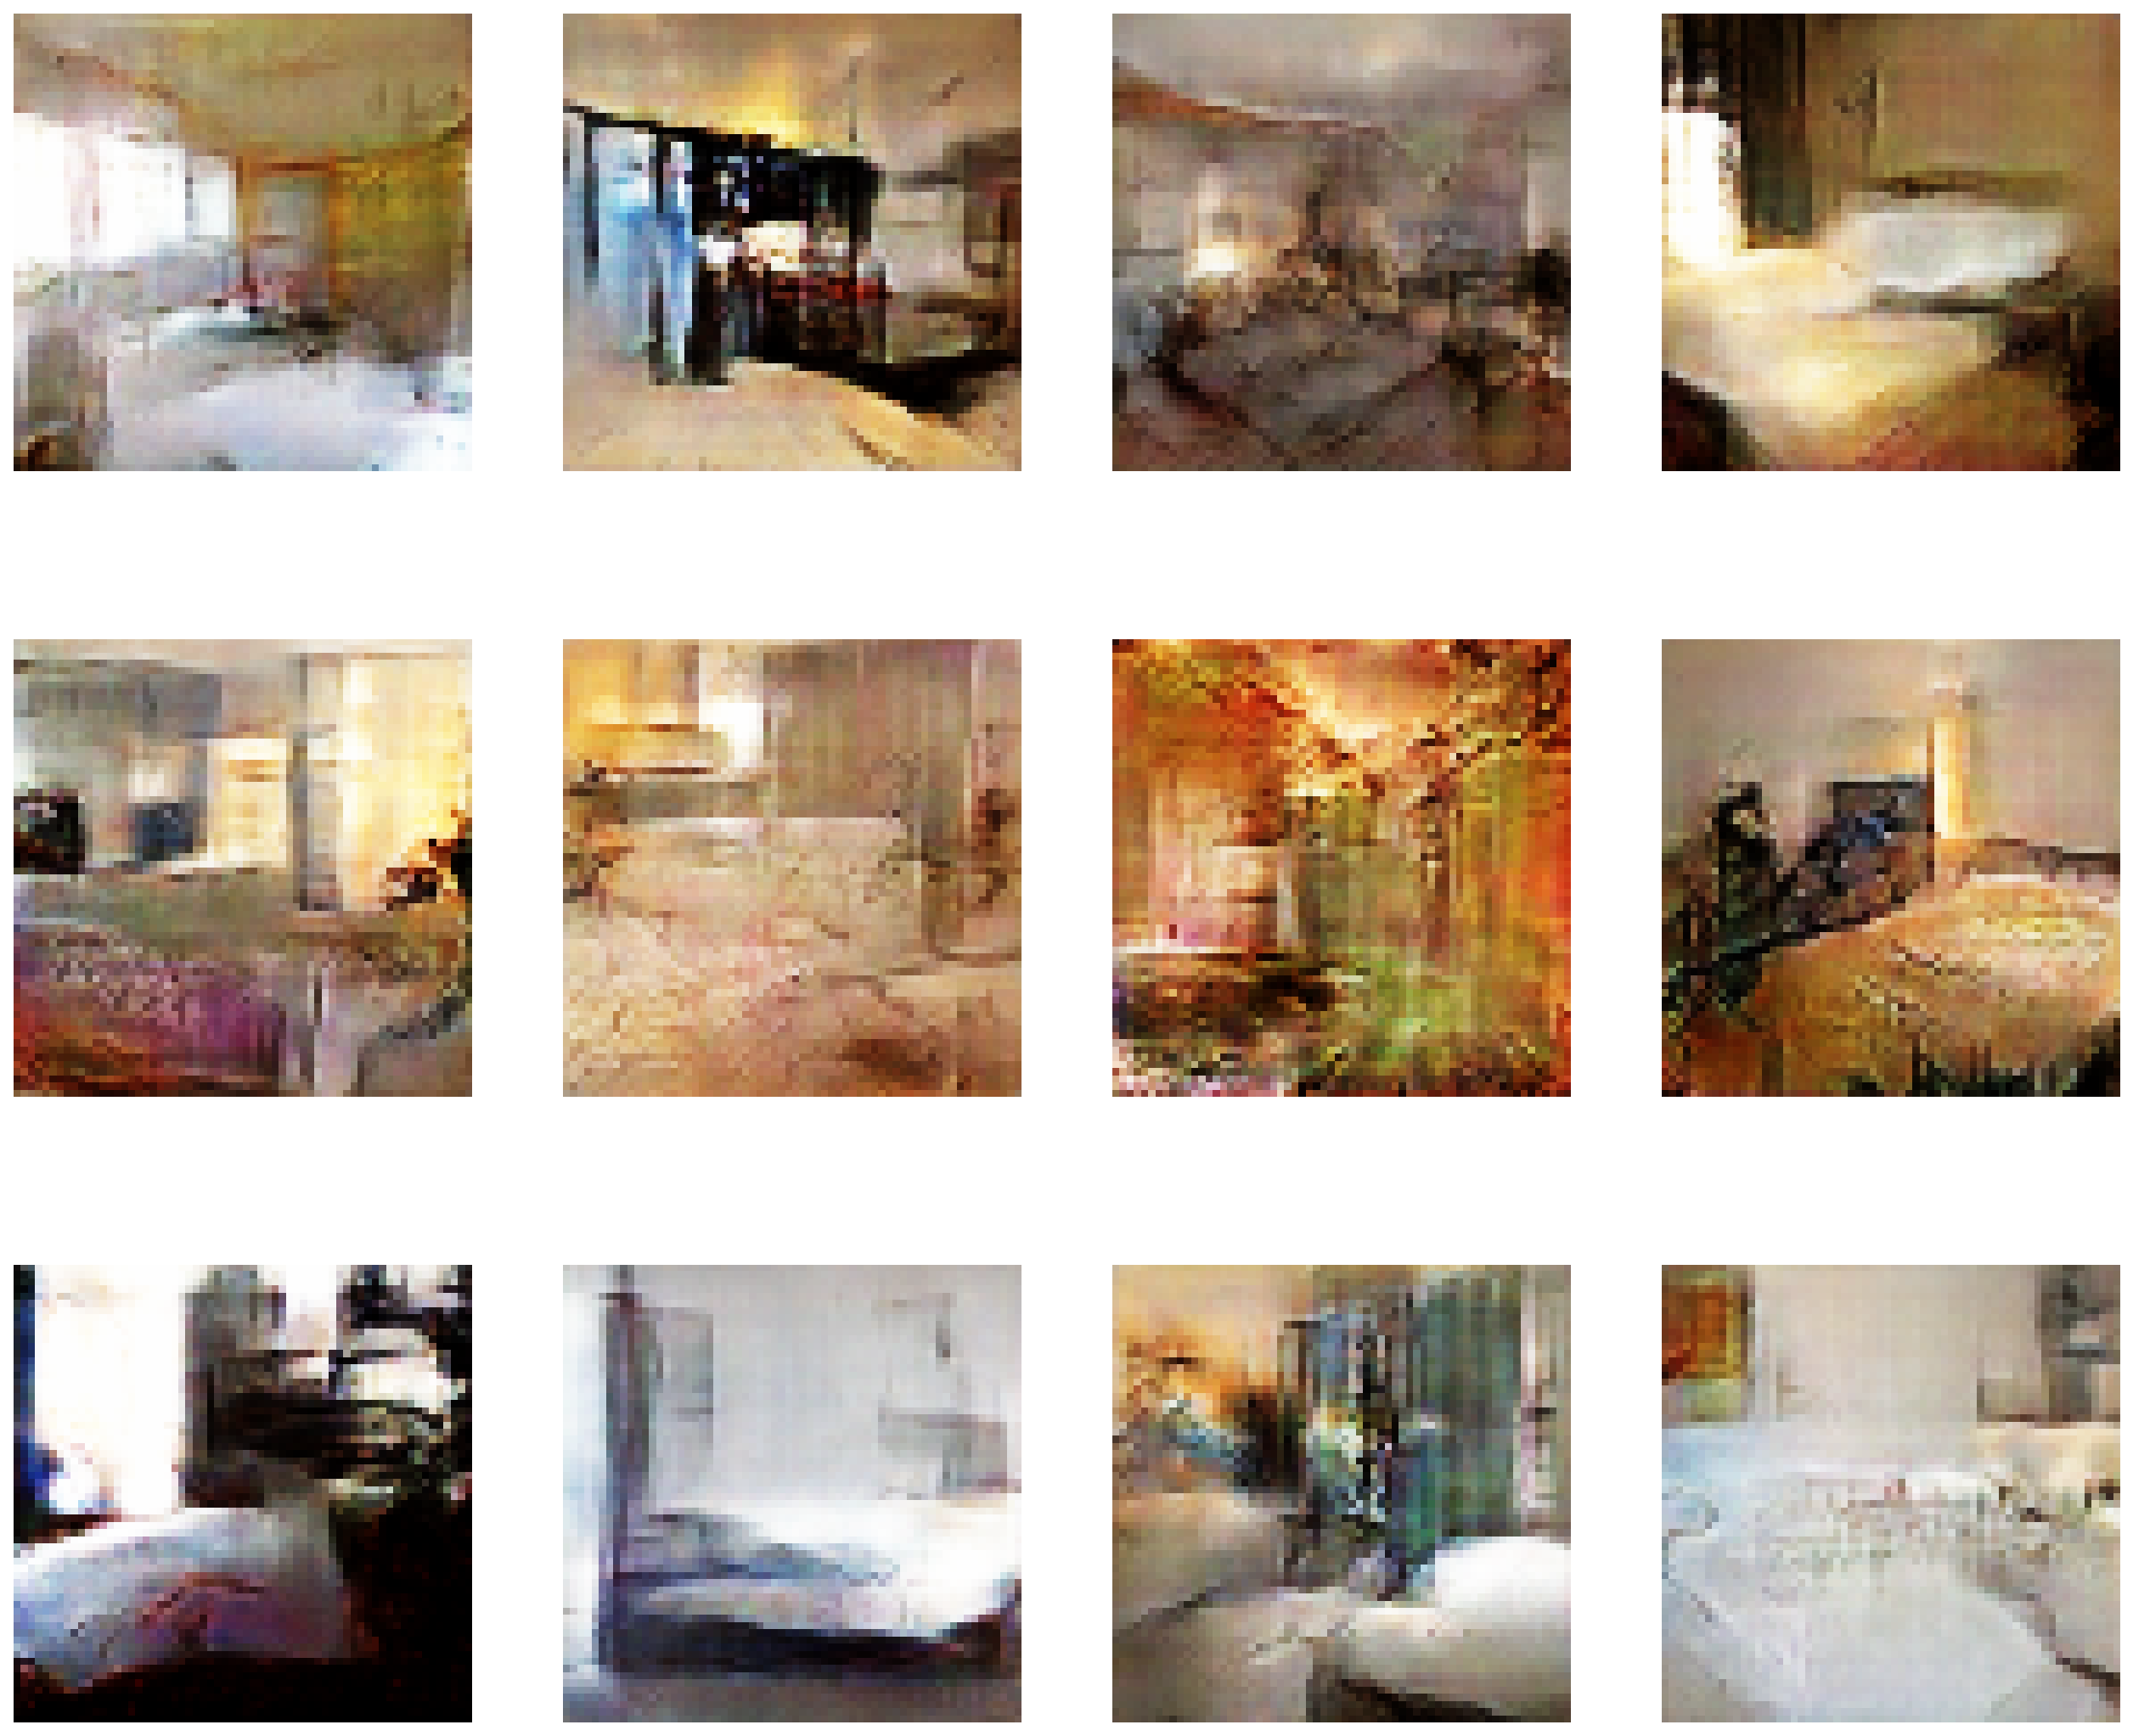

In [121]:
plt.figure(figsize=(20, 60), dpi=160)
i = 0
for im in fake_image[0:12]:
    i += 1

    plt.subplot(10,4, i)
    plt.axis('off')
    plt.imshow(np.transpose(unorm(im),(1,2,0)))

In [122]:
with torch.no_grad():
    generated_embeddings = model(transform(unorm(fake_image)).cuda()).cpu().numpy()

In [123]:
calculate_fid(real_embeddings, generated_embeddings)

943.1823237309152

In [132]:
a =  torch.randn(1, noiseDimension, 1, 1)
b =  torch.randn(1, noiseDimension, 1, 1)
outputs = []
ratios = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for i in ratios:
    c = a * i + (1-i) * b
    outputs.append(c)
result = torch.cat(outputs, dim=0).cuda()

In [136]:
with torch.no_grad():
    interpolate = generator(result).detach().cpu()

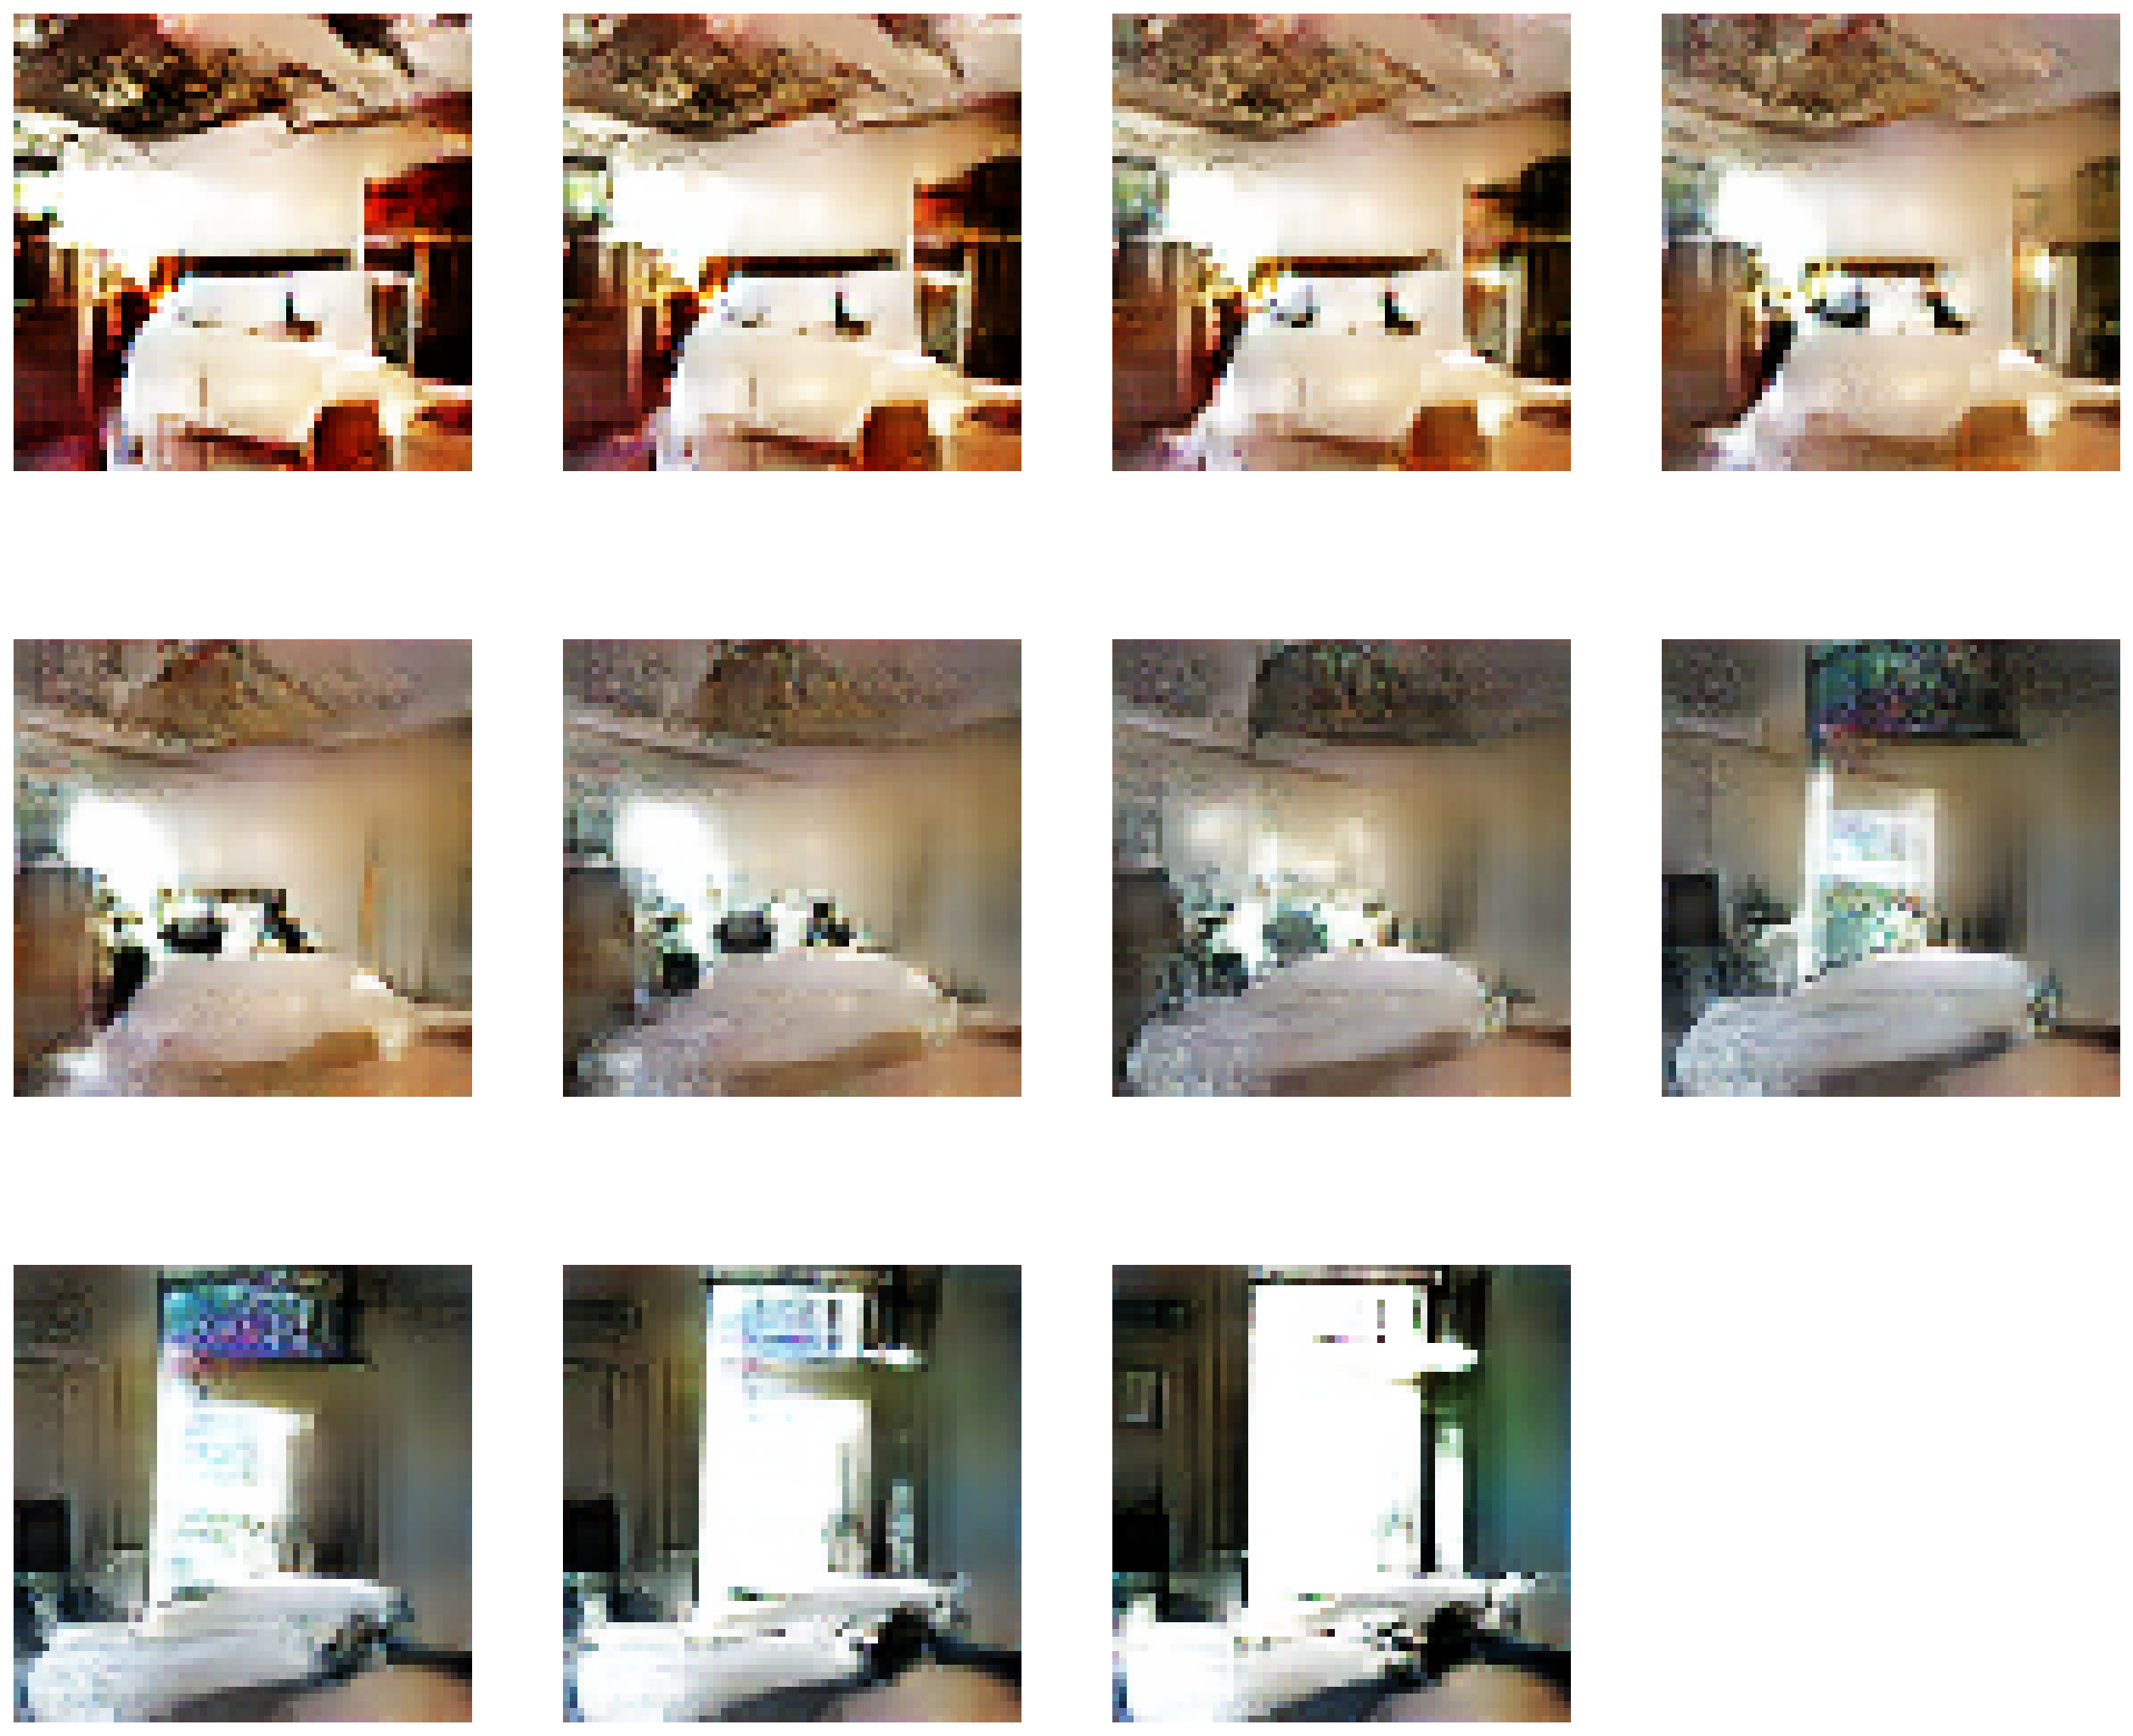

In [137]:
plt.figure(figsize=(20, 60), dpi=160)
i = 0
for im in interpolate:
    i += 1

    plt.subplot(10,4, i)
    plt.axis('off')
    plt.imshow(np.transpose(unorm(im),(1,2,0)))